In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

1. Load the data into R and name the columns to better identify the board (following an
ordering from left to right and from top to bottom). Check for missing values. 

In [37]:
df = pd.read_csv("tic.tac.txt", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [38]:
print(df.isnull().sum())

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64


In [39]:
df_encoded = pd.get_dummies(df, columns=[0, 1, 2, 3, 4, 5, 6, 7, 8])
df_encoded.head()

,9,0_b,0_o,0_x,1_b,1_o,1_x,2_b,2_o,2_x,...,5_x,6_b,6_o,6_x,7_b,7_o,7_x,8_b,8_o,8_x
0,positive,False,False,True,False,False,True,False,False,True,...,False,False,False,True,False,True,False,False,True,False
1,positive,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
2,positive,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,True
3,positive,False,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False
4,positive,False,False,True,False,False,True,False,False,True,...,False,True,False,False,False,True,False,True,False,False


In [41]:
df_encoded['target'] = df[9].apply(lambda x: 1 if x == 'positive' else 0)
df_encoded.drop(9, axis=1, inplace=True)
df_encoded.head()

,0_b,0_o,0_x,1_b,1_o,1_x,2_b,2_o,2_x,3_b,...,6_b,6_o,6_x,7_b,7_o,7_x,8_b,8_o,8_x,target
0,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,True,False,False,True,False,1
1,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,True,False,1
2,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,True,False,False,False,True,1
3,False,False,True,False,False,True,False,False,True,False,...,False,True,False,True,False,False,True,False,False,1
4,False,False,True,False,False,True,False,False,True,False,...,True,False,False,False,True,False,True,False,False,1


2. Read the "data splitting" section on the caret web page. Then split the data into 70%
training and 30% test by keeping the original class proportion (check
“createDataPartition()” function). 

In [42]:
# Stratified sampling ensures that the class distribution 
# in the training and test sets is representative of the original dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_encoded.iloc[:, :-1], df_encoded.iloc[:, -1], test_size=0.3, stratify=df_encoded.iloc[:, -1], random_state=42)


In [43]:
df.iloc[:, -1].value_counts(), y_train.value_counts(), y_test.value_counts()

(9
 positive    626
 negative    332
 Name: count, dtype: int64,
 target
 1    438
 0    232
 Name: count, dtype: int64,
 target
 1    188
 0    100
 Name: count, dtype: int64)

3. The values of the measures used for selecting the best model (by default, the accuracy
and/or the kappa measures are used for classification models) are printed by typing the
name of the model in the console

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, cohen_kappa_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score


classifiers = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Neural Network': MLPClassifier(random_state=42),
    'Nearest Neighbors': KNeighborsClassifier(),
    'SVM (Linear Kernel)': SVC(kernel='linear', random_state=42)
}

accuracy_scores = []
kappa_scores = []
auc_scores = []

for clf_name, clf in classifiers.items():
    accuracy_scorer = make_scorer(accuracy_score)
    kappa_scorer = make_scorer(cohen_kappa_score)

    accuracy = cross_val_score(clf, X_train, y_train, cv=5, scoring=accuracy_scorer).mean()
    kappa = cross_val_score(clf, X_train, y_train, cv=5, scoring=kappa_scorer).mean()
    auc = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    kappa_scores.append(kappa)

# 

In [59]:
pd.DataFrame({'Classifier': list(classifiers.keys()), 'accuracy': accuracy_scores, "kappa": kappa_scores, "auc":auc_scores})


,Classifier,accuracy,kappa,auc
0,Naive Bayes,0.664179,0.247395,0.742380
1,Decision Tree,0.928358,0.841585,0.919979
2,Neural Network,0.977612,0.950168,0.993541
3,Nearest Neighbors,0.916418,0.809172,0.973263
4,SVM (Linear Kernel),0.985075,0.966536,0.985776


In [46]:
from sklearn.metrics import confusion_matrix

confusion_matrices = {}
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[clf_name] = cm
print("\nConfusion Matrices:")
print(confusion_matrices)



Confusion Matrices:
{'Naive Bayes': array([[ 44,  56],
       [ 38, 150]]), 'Decision Tree': array([[ 87,  13],
       [ 12, 176]]), 'Neural Network': array([[ 95,   5],
       [  0, 188]]), 'Nearest Neighbors': array([[ 85,  15],
       [  3, 185]]), 'SVM (Linear Kernel)': array([[ 94,   6],
       [  0, 188]])}


/home/igor/.conda/envs/ml/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


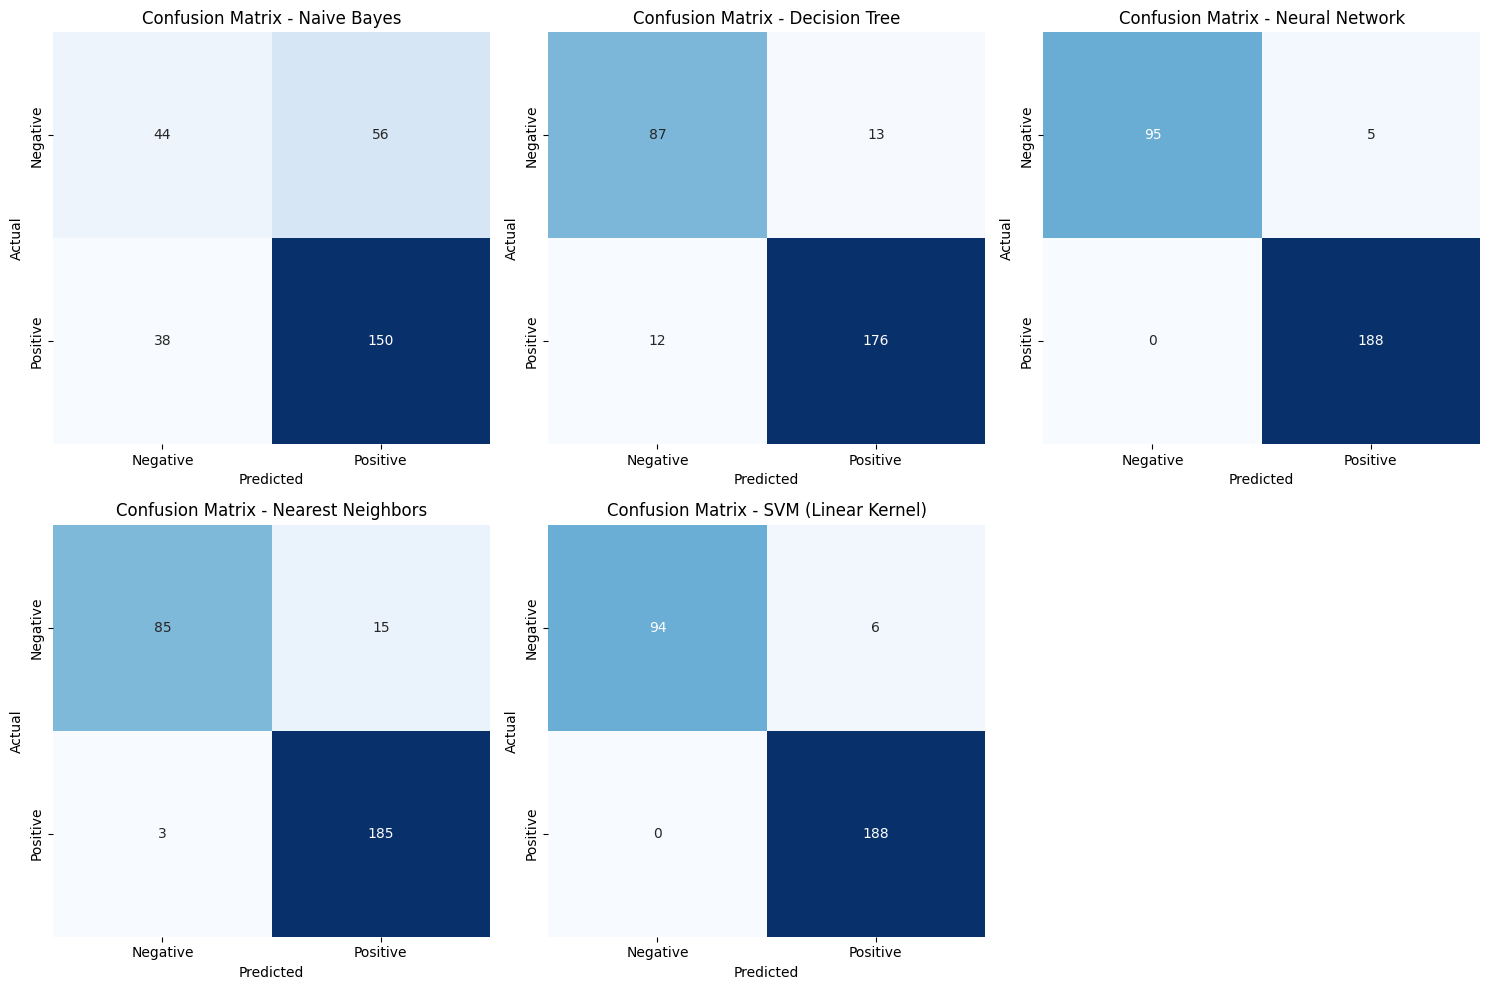

In [50]:
import seaborn as sns

plt.figure(figsize=(15, 10))

for i, (clf_name, cm) in enumerate(confusion_matrices.items(), 1):
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {clf_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


/home/igor/.conda/envs/ml/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


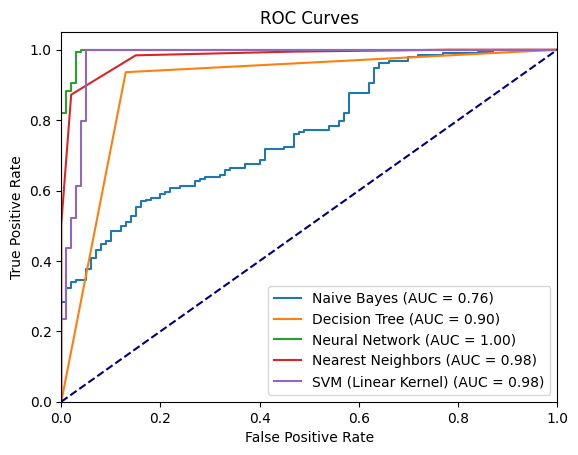

In [49]:
from sklearn.metrics import roc_curve, auc

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:  # For classifiers without predict_proba, use decision function
        y_score = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()
